
This notebook uses the outputs
--- workflow/rules/20_preprocessing::prep_t2t_seq_class_cache_file
--- data/sample_phylo_order.tsv
--- workflow/rules/75_assm_stats::merge_all_sequence_class_annotations
--- workflow/rules/75_assm_stats::dump_suppl_tables_contiguity
as input, and produces a heatmap for the percentage of contiguously
assembled sequence per sample/Y sequence class (T2T-Y length is 100%).

Repository directory:  /home/local/work/code/github/project-male-assembly
Execution directory:  /home/local/work/code/github/project-male-assembly/notebooks/plotting/contig_heatmap
Working directory:  /home/local/work/data/sig_chrY/paper
Output directory:  /home/local/work/data/sig_chrY/paper/output/figures


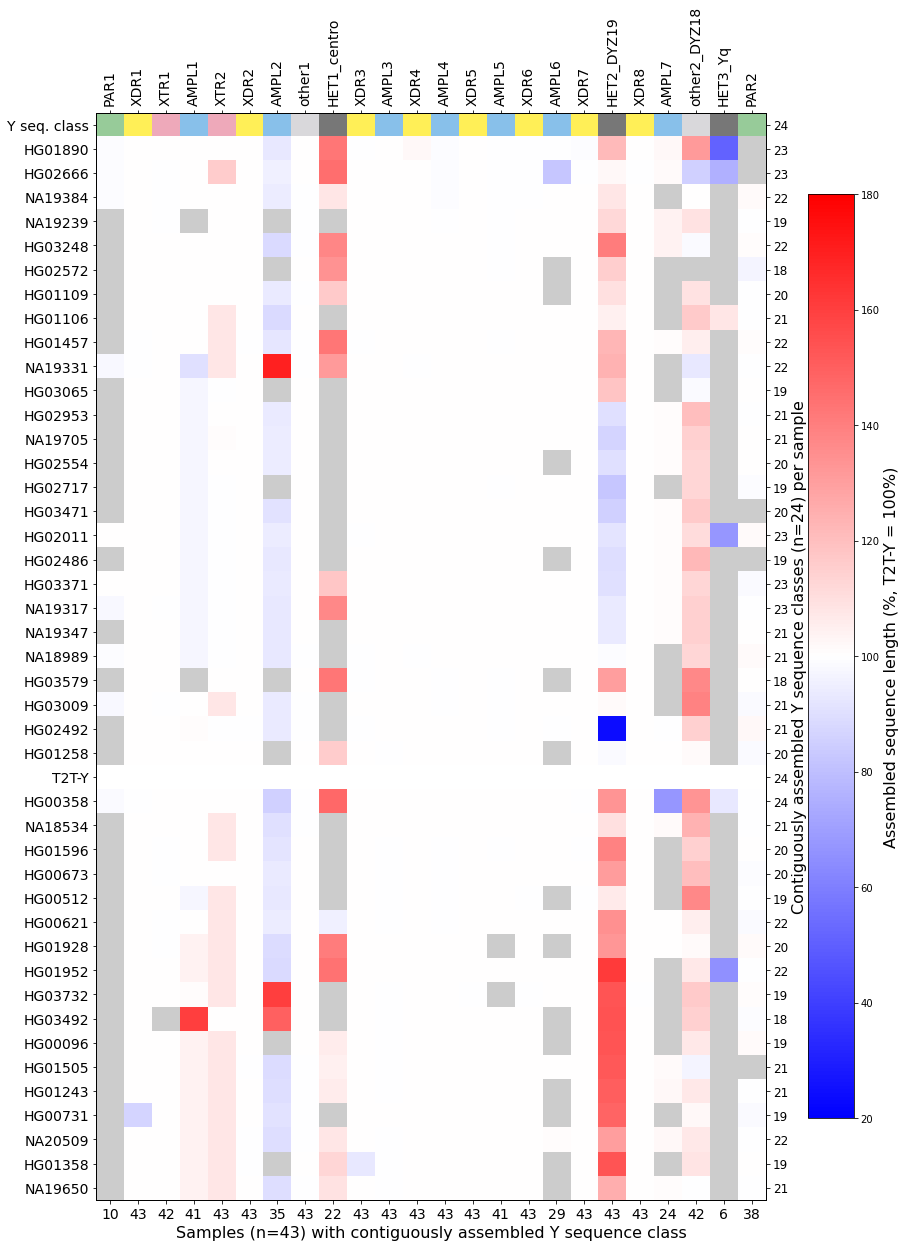

In [3]:
import pathlib as pl

import pandas as pd
import numpy as np
import collections as collect

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.patches as mpt

desc="""
This notebook uses the outputs
--- workflow/rules/20_preprocessing::prep_t2t_seq_class_cache_file
--- data/sample_phylo_order.tsv
--- workflow/rules/75_assm_stats::merge_all_sequence_class_annotations
--- workflow/rules/75_assm_stats::dump_suppl_tables_contiguity
as input, and produces a heatmap for the percentage of contiguously
assembled sequence per sample/Y sequence class (T2T-Y length is 100%).
"""

# required to have text output as "text fields"
# and not individual objects
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

save_plots = True

print(desc)

repo_dir = pl.Path('/home/local/work/code/github/project-male-assembly').resolve(strict=True)
exec_dir = pl.Path('.').resolve(strict=True)
wd_dir = pl.Path('/home/local/work/data/sig_chrY/paper').resolve(strict=True)
out_dir = pl.Path('/home/local/work/data/sig_chrY/paper/output/figures').resolve(strict=True)

print('Repository directory: ', repo_dir)
print('Execution directory: ', exec_dir)
print('Working directory: ', wd_dir)
print('Output directory: ', out_dir)
print('=================================')

drop_samples = [
    'HG02666',
    'NA19384',
    'HG01457',
    'NA18989',
    'NA24385'
]

seq_classes_t2t_file = wd_dir / pl.Path('annotation_tables', 'T2T.chrY-seq-classes.tsv')
sqcls_t2t = pd.read_csv(seq_classes_t2t_file, header=0, sep='\t')
num_sqcls = sqcls_t2t.shape[0]

# The sample order in the phylogenetic tree starts at 1 (biologists...),
# which is fitting here because at row index 0, the sequence classes
# should be plotted. Additionally, the T2T sample is included in the sample
# order at position 28.
phylo_order_file = repo_dir / pl.Path('data', 'sample_phylo_order.tsv')
phylo_order = pd.read_csv(phylo_order_file, sep='\t', header=0)
phylo_order.sort_values('order_top', ascending=True, inplace=True)
phylo_order = phylo_order.loc[~phylo_order['sample'].isin(drop_samples), :].copy()

# 44 samples plus sequence classes at top plus T2T-Y in the middle
plot_data = np.zeros((phylo_order.shape[0] + 1, num_sqcls, 3), dtype=np.float32)
plot_data[:,:,:] = 0.8
assert plot_data.shape[0] == 45

name_col_idx_map = dict()
seq_class_names = []

row_idx = 0
red, green, blue = 0, 1, 2
for row in sqcls_t2t.itertuples(index=True):
    plot_data[row_idx, row.Index, red] = row.red
    plot_data[row_idx, row.Index, green] = row.green
    plot_data[row_idx, row.Index, blue] = row.blue
    name_col_idx_map[row.name] = row.Index
    seq_class_names.append(row.name)

# table containing percent of assembled sequence length relative to T2T-Y (=100%)
# for contiguously assembled sequence classes
seqclass_file = wd_dir / pl.Path('stats/contiguity', 'pctassm-ctgly-seqcls.by-sample.HIFIRW.ONTUL.na.chrY.pivot.tsv')
seqclasses = pd.read_csv(seqclass_file, sep='\t', header=0, comment='#', index_col=0)
num_samples = seqclasses.index.size

sample_ctgly_sqcls = (seqclasses.values > 0).sum(axis=0)

samples = ['Y seq. class']
right_y_ticklabels = [f'{num_sqcls}']

# determine range of percentage values with 100 as midpoint
min_assm = seqclasses.values[seqclasses > 0].flatten().min()
max_assm = seqclasses.values[seqclasses > 0].flatten().max()
lower_range = 100 - min_assm // 10 * 10
upper_range = (max_assm // 10 * 10 + 10) - 100
set_range = max(lower_range, upper_range)

norm_scaler = mpl.colors.Normalize(vmin=100 - set_range, vmax=100 + set_range)
cmap = cm.bwr
cmap_norm = cm.ScalarMappable(norm=norm_scaler, cmap=cmap)


for row in phylo_order.itertuples():
    if row.sample in drop_samples:
        continue
    row_idx = row.order_top
    sample = row.sample
    if row_idx == 27:
        assert sample == 'T2T-Y'
        samples.append(sample)
        plot_data[row_idx, :, red] = 1
        plot_data[row_idx, :, green] = 1
        plot_data[row_idx, :, blue] = 1
        right_y_ticklabels.append(f'{num_sqcls}')
        continue

    if sample.startswith('HC'):
        if sample in ['HC02666', 'HC01457']:
            sample = sample.replace('HC', 'HG')
        else:
            sample = sample.replace('HC', 'NA')
    samples.append(sample)
    subset = seqclasses.loc[row.sample, :]
    total_ctgly = 0
    for column, percentage in enumerate(subset.values, start=0):
        if np.isclose(percentage, 0.):
            continue
        total_ctgly += 1
        r,g,b,a = cmap_norm.to_rgba(percentage)
        plot_data[row_idx, column, red] = r
        plot_data[row_idx, column, green] = g
        plot_data[row_idx, column, blue] = b

    right_y_ticklabels.append(f'{total_ctgly}')


fig, ax = plt.subplots(figsize=(15,20))
_ = ax.imshow(plot_data, aspect='auto')
_ = ax.set_yticks(np.arange(plot_data.shape[0]))
_ = ax.set_yticklabels(samples, fontsize=14)

ax2 = ax.twinx()
_ = ax2.set_yticks(np.arange(plot_data.shape[0]))
_ = ax2.set_yticklabels(right_y_ticklabels, fontsize=12)
_ = ax2.yaxis.tick_right()
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(f'Contiguously assembled Y sequence classes (n={num_sqcls}) per sample', fontsize=16)

_ = ax.set_xticks(np.arange(len(seq_class_names)))
_ = ax.set_xticklabels(seq_class_names, fontsize=14, rotation=90)
_ = ax.xaxis.tick_top()
_ = ax.set_xlabel(None)

ax3 = ax.twiny()
_ = ax3.set_xticks(np.arange(len(seq_class_names)))
_ = ax3.set_xticklabels(sample_ctgly_sqcls, fontsize=14)
ax3.set_xlim(ax.get_xlim())
ax3.xaxis.tick_bottom()
ax.xaxis.tick_top()
ax3.set_xlabel(f'Samples (n={num_samples}) with contiguously assembled Y sequence class', fontsize=16)
ax3.xaxis.set_label_position("bottom")

cmap_legend = plt.colorbar(
    cmap_norm,
    shrink=0.85,
)
cmap_legend.set_label(
    label='Assembled sequence length (%, T2T-Y = 100%)',
    size=16
)

if save_plots:
    plt.savefig(
        out_dir / pl.Path('Heatmap_ctgly-assm_seqclasses_pct.pdf'),
        bbox_inches='tight',
        #bbox_extra_artists=[cmap_legend]
    )
    plt.savefig(
        out_dir / pl.Path('Heatmap_ctgly-assm_seqclasses_pct.png'),
        bbox_inches='tight',
        #bbox_extra_artists=[cmap_legend],
        dpi=150
    )